# Tutorial 9 (Introduction to AI)

# Genetic Algorithms

## Part 2: Travelling Salesman with GAs

This second part of the tutorial works through another example, which forces us to think a little more about crossover and mutation.

In this example we will consider the Travelling Salesman Problem.  This well known problem consists of a list of cities, and the distance between each city (either directly given, or as here, implied by location data).  The problem is to find the shortest route from a starting city back to itself, visiting each city exactly once along the way.

The problem is known to be NP-hard, hence our best guess is that the best algorithm for finding a solution is exponential, so again Genetic Algorithms might provide a good heuristic search for solutions.

Often with difficult problems, the optimal solution is not known, and a merely good solution might suffice.  

Our sample data comes from the country of Western Sahara (since it gives us a small, but non-trivial dataset), which consists of 29 cities.  You can find some considerably bigger problems here, including results: http://www.math.uwaterloo.ca/tsp/world/countries.html

First, let's import libraries and define some values to be used through the problem:

* the number of cities (which will be read from the file)

* the size of the population of routes

* the crossover rate

* the mutation rate

* the population itself

In [ ]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

cities = 0
population = 64
pc = 0.7
pm = 0.08
generations = 50
routes = []

The first method reads in the data, returning a DataFrame.  (The file is space separated.)

In [ ]:
def read_data():
    path = "."
    data = pd.read_csv("wi29.tsp.txt", header=None, delimiter=r"\s+")
    data.index += 1
    return data

data = read_data()
print(data[:5])

   0           1           2
1  1  20833.3333  17100.0000
2  2  20900.0000  17066.6667
3  3  21300.0000  13016.6667
4  4  21600.0000  14150.0000
5  5  21600.0000  14966.6667


A solution is a tour, visiting each city once.  So the chromosome in this case is going to be a list of cities, *with no duplicates*.  A initial tour is given by:

In [ ]:
 def initialise_chromosome():
    tour = list(range(1,cities+1))
    random.shuffle(tour)
    return tour

cities = data.shape[0]
tour = initialise_chromosome()
print(tour)

[21, 20, 29, 26, 28, 25, 12, 18, 27, 17, 19, 3, 23, 24, 4, 1, 22, 10, 6, 13, 5, 15, 2, 8, 16, 11, 14, 7, 9]


The following method displays a tour.  Obviously, from the random initial tour the result does not look very systematic.

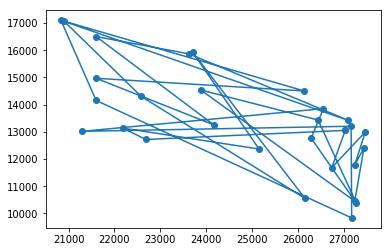

In [ ]:
def display(tour):
    xs = [data.loc[c][1] for c in tour]
    ys = [data.loc[c][2] for c in tour]
    xs.append(data.loc[tour[0]][1])
    ys.append(data.loc[tour[0]][2])
    plt.plot(xs, ys, '-o')
    plt.show()

display(tour)

Next we define the fitness.  This derives simply from the length of the tour.  The method returns two values - the reciprocal of the length of the tour which will be used as the fitness, and the length itself, which will be useful elsewhere.

In [ ]:
def distance(x, y):
    return math.sqrt((y[0]-x[0])**2 + (y[1]-x[1])**2)

def fitness(tour):
    dist = 0
    i=0
    while(i<len(tour)):
        c1=tour[i]
        c2=tour[(i+1) % len(tour)] #back to the beginning
        c11 = data.loc[c1][1]
        c12 = data.loc[c1][2]
        c21 = data.loc[c2][1]
        c22 = data.loc[c2][2]
        dist = dist + distance([c11,c12],[c21,c22])
        i=i+1
    return (1/dist), dist

Crossover is more complicated for this problem.  We can't just split in two and swap over the two tail halves, because the tours are not allowed to have duplicates in them and a simple swap will almost certainly introduce duplicates.

What happens instead is that we identify a section of the tour that we would like to crossover, and keep this.  The elements of this section are then removed from the tour it is being crossed with, and the section is inserted in position.

For example, suppose we have crossing over $[1,8,4,5,7,6,2,3]$ and $[1,5,8,2,6,4,7,3]$.  And suppose that [2:6] have been chosen to crossover.  From the first list (blanking out the non-selected elements with *):
$$
[*,*,4,5,7,6,*,*]
$$
These elements are removed from the second list:
$$
[1,*,8,2,*,*,*,3]
$$
And the remaining elements are put into position:
$$
[1,8,*,*,*,*,2,3]
$$
Finally the lists are combined to give
$$
[1,8,4,5,7,6,2,3]
$$

In [ ]:
def crossover(tour1, tour2, i, j):
    section1 = tour1[i:j]
    remains = []
    for c in tour2:
        if not(c in section1):
            remains.append(c)
    new_tour=remains[0:i]
    new_tour=new_tour+section1
    new_tour=new_tour+remains[i:]
    return new_tour

xover = crossover([1,2,3,4,5,6,7,8],[8,7,6,5,4,3,2,1],2,6)
print(xover)

[8, 7, 3, 4, 5, 6, 2, 1]


Again, mutation can't work simply by changing an element of the tour, as no duplicates are allowed.  Instead, what is used here is to swap two randomly chosen elements of the tour.

In [ ]:
def mutation_swap(tour):
    r = random.random()
    if r<pm:
        i = random.randint(1,cities-1)
        j = random.randint(1,cities-1)
        tmp = tour[i]
        tour[i]=tour[j]
        tour[j] = tmp
    return tour

Another form of mutation is to take a section of the tour and reverse its order.

In [ ]:
def mutation_reverse(tour):
    r = random.random()
    if r<pm:
        i = random.randint(1,cities-1)
        j = random.randint(1,cities-1)
        tmp = tour[i:j]
        tmp.reverse()
        tour[i:j] = tmp
    return tour

The roulette wheel selection carries over more or less unchanged from the n-queens example.

In [ ]:
def probability(tour):
    return fitness(tour)[0] #/ max_fitness

def random_pick(population, probabilities):
    populationWithProbabilty = zip(population, probabilities)
    total = sum(w for c, w in populationWithProbabilty)
    r = random.uniform(0, total)
    #print("wheel",r,"total",total,sep=" ")
    upto = 0
    for c, w in zip(population, probabilities):
        if upto + w >= r:
            return c
        upto += w

The next generation of tours is generated by using roulette wheel selection to pick two existing tours, apply crossover (and mutation) to generate two new tours and repeating this to get a population of twice the initial size, then using tournament selection to cut this back down to the original size.

In [ ]:
def next_gen():
    next_gen = []
    probabilities = [probability(r) for r in routes]
    for i in range(0,len(routes)):
        x = random_pick(routes, probabilities)
        y = random_pick(routes, probabilities)
        rand = random.uniform(0,1)
        if rand < pc:
            i = random.randint(1,cities-1)
            j = random.randint(i,cities-1)
            c1 = crossover(x,y,i,j)
            c2 = crossover(y,x,i,j)
        else:
            c1=x
            c2=y
        m1s = mutation_swap(c1)
        m2s = mutation_swap(c2)
        m1 = mutation_reverse(m1s)
        m2 = mutation_reverse(m2s)
        next_gen.append(m1)
        next_gen.append(m2)
    random.shuffle(next_gen)
    j=0
    final_next_gen = []
    while j<len(next_gen):
        if fitness(next_gen[j])>fitness(next_gen[j+1]):
            final_next_gen.append(next_gen[j])
        else:
            final_next_gen.append(next_gen[j+1])
        j=j+2
    return final_next_gen

We also need an initial population of routes.

In [ ]:
def initial():
    for i in range(0,population):
        routes.append(initialise_chromosome())

This final piece of code runs the GA, and after each generation prints the best three distance.  On completion it displays the tour as a list and as a graph.  It takes a while to run!!

The optimum result is 27603.

generation 0
[80503.88151621498, 86193.61836260767, 86777.85538790665]
generation 1
[81490.93563081865, 84073.02739856832, 86777.85538790665]
generation 2
[74103.0979627178, 80479.10527085818, 81405.19436463008]
generation 3
[75758.56913019565, 80795.97347598677, 82768.184683115]
generation 4
[75758.56913019565, 75758.56913019565, 78430.78625159604]
generation 5
[70223.0357731616, 70527.23611243551, 70527.23611243551]
generation 6
[70527.23611243551, 70527.23611243551, 70527.23611243551]
generation 7
[70317.10813419722, 70486.40246903556, 70527.23611243551]
generation 8
[67854.03008791289, 69019.2490284878, 70317.10813419722]
generation 9
[65487.41499309745, 67854.03008791289, 67854.03008791289]
generation 10
[63682.10338638208, 65766.18054873, 66668.17707340997]
generation 11
[63045.79295683816, 63573.24457910802, 65766.18054873]
generation 12
[62073.56486311021, 62211.41392834564, 63045.79295683816]
generation 13
[62073.56486311021, 62211.41392834564, 63045.79295683816]
generation 14

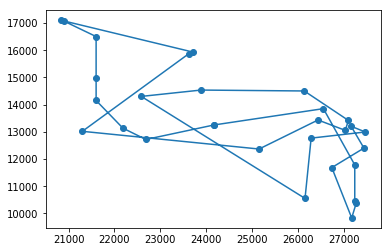

In [ ]:
data = read_data()
cities = data.shape[0]

initial()

dists=[]

for i in range(0,generations):
    print("generation", i, sep=" ")
    routes = next_gen()
    #display the top three distance for the current generation
    dists = [fitness(r)[1] for r in routes]
    dists.sort()
    print(dists[:3])

soln=[]
for route in routes:
    if fitness(route)[1]==dists[0]:
        soln = route

print(soln)
display(soln)

If you've run this for fifty generation (which will take a few minutes), you will probably see that it is still converging.  And the graph will show you that sensible paths have been generated but that they are not quite joined up properly.  

You might try running it for more generations/changing the population size/changing the crossover and mutation rates (perhaps different rates for the two types of mutation).  You might also experiment with the way that the next generation is built,  perhaps allowing the best solutions from the previous generation to survive into the next.  

Finally I should add that GAs might not be the best way to solve this problem (or the n-queens problem), but that this kind of heuristic search is one way to approach a problem with an apparently infeasible search space.